In [30]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import models, layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Normalize Data

In [3]:
data_path = '../dataset'

test_data = data_path + '/test'
train_data = data_path + '/train'
validation_data = data_path + '/validation'

for split_name, split_path in zip(['Train', 'Validation', 'Test'], [train_data, validation_data, test_data]):
    print(f"{split_name} set:")
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if os.path.isdir(class_dir):
            count = len([img for img in os.listdir(class_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"  {class_name}: {count} images")
    print()

Train set:
  dimes: 28 images
  nickels: 849 images
  pennies: 899 images
  quarters: 875 images

Validation set:
  dimes: 4 images
  nickels: 182 images
  pennies: 192 images
  quarters: 187 images

Test set:
  dimes: 4 images
  nickels: 183 images
  pennies: 194 images
  quarters: 188 images



In [6]:
import random
from tensorflow.keras.preprocessing.image import save_img

# Set paths
dime_train_dir = os.path.join(train_data, 'dimes')
dime_val_dir = os.path.join(validation_data, 'dimes')
dime_test_dir = os.path.join(test_data, 'dimes')

# Augmentation generators
strong_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

light_aug = ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.95, 1.05],
    fill_mode='nearest'
)

def augment_images(target_count, source_dir, dest_dir, aug_gen, prefix='aug'):
    os.makedirs(dest_dir, exist_ok=True)
    existing = [f for f in os.listdir(dest_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current = len(existing)
    
    if current >= target_count:
        print(f"{dest_dir} already has {current} images.")
        return

    print(f"Augmenting {dest_dir}: {current} -> {target_count}")
    
    source_imgs = [f for f in os.listdir(source_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if not source_imgs:
        print(f"Warning: No source images found in {source_dir}. Skipping augmentation.")
        return
    random.shuffle(source_imgs)
    
    img_idx = 0
    save_idx = current

    while current < target_count:
        img_path = os.path.join(source_dir, source_imgs[img_idx % len(source_imgs)])
        img = load_img(img_path, target_size=(224, 224))
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        aug_img = next(aug_gen.flow(x, batch_size=1))[0]
        save_path = os.path.join(dest_dir, f'{prefix}_{save_idx}.png')
        save_img(save_path, aug_img)

        current += 1
        save_idx += 1
        img_idx += 1

# Apply augmentations
augment_images(target_count=850, source_dir=dime_train_dir, dest_dir=dime_train_dir, aug_gen=strong_aug)
augment_images(target_count=180, source_dir=dime_train_dir, dest_dir=dime_val_dir, aug_gen=light_aug)
augment_images(target_count=180, source_dir=dime_train_dir, dest_dir=dime_test_dir, aug_gen=light_aug)


Augmenting ../dataset/train\dimes: 28 -> 850
Augmenting ../dataset/validation\dimes: 4 -> 180
Augmenting ../dataset/test\dimes: 4 -> 180


Train Model

In [13]:
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    brightness_range = [0.8, 1.2],
    horizontal_flip = True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale= 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)


train_generator = train_datagen.flow_from_directory(
    '../dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    '../dataset/validation',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
)

test_generator = test_datagen.flow_from_directory(
    '../dataset/test',
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)



Found 3473 images belonging to 4 classes.
Found 741 images belonging to 4 classes.
Found 745 images belonging to 4 classes.


In [14]:
train_dir = '../dataset/train'

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{class_name}: {count} images")

dimes: 850 images
nickels: 849 images
pennies: 899 images
quarters: 875 images


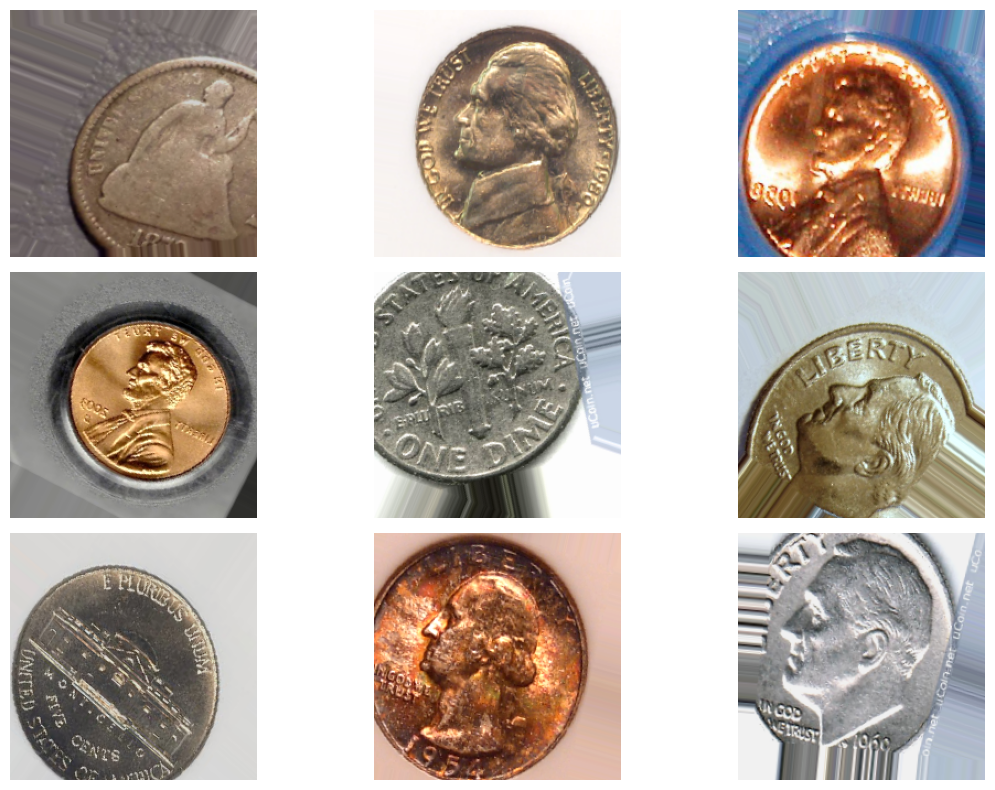

In [15]:
images, labels = next(train_generator)
plt.figure(figsize=(12, 8))
for i in range(9):  # Display 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [16]:
model = models.Sequential([
   layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
   layers.MaxPool2D(pool_size=(2, 2)),
   layers.Conv2D(64, (3, 3), activation='relu'),
   layers.MaxPool2D(pool_size=(2, 2)),
   layers.Flatten(),
   layers.Dense(64, activation='relu'),
   layers.Dropout(0.5),
   layers.Dense(4, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='best_coin_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, earlystop]

In [18]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks= callbacks)

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.2032 - accuracy: 0.5249
Epoch 1: val_accuracy improved from -inf to 0.67341, saving model to best_coin_model.h5
109/109 [==============================] - 90s 816ms/step - loss: 1.2032 - accuracy: 0.5249 - val_loss: 0.8120 - val_accuracy: 0.6734
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.7390 - accuracy: 0.7031
Epoch 2: val_accuracy improved from 0.67341 to 0.78408, saving model to best_coin_model.h5
109/109 [==============================] - 84s 771ms/step - loss: 0.7390 - accuracy: 0.7031 - val_loss: 0.6150 - val_accuracy: 0.7841
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.7688
Epoch 3: val_accuracy improved from 0.78408 to 0.82591, saving model to best_coin_model.h5
109/109 [==============================] - 85s 778ms/step - loss: 0.6287 - accuracy: 0.7688 - val_loss: 0.5152 - val_accuracy: 0.8259
Epoch 4/50
109/109 [====================

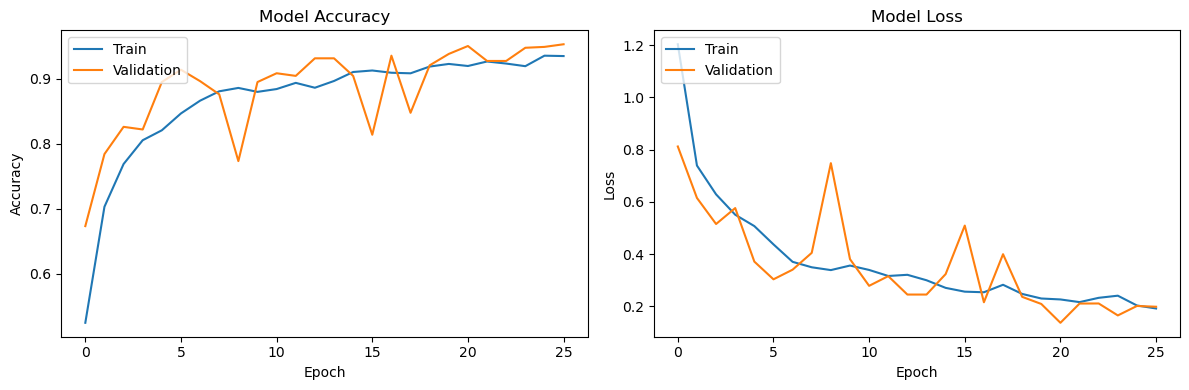

In [44]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

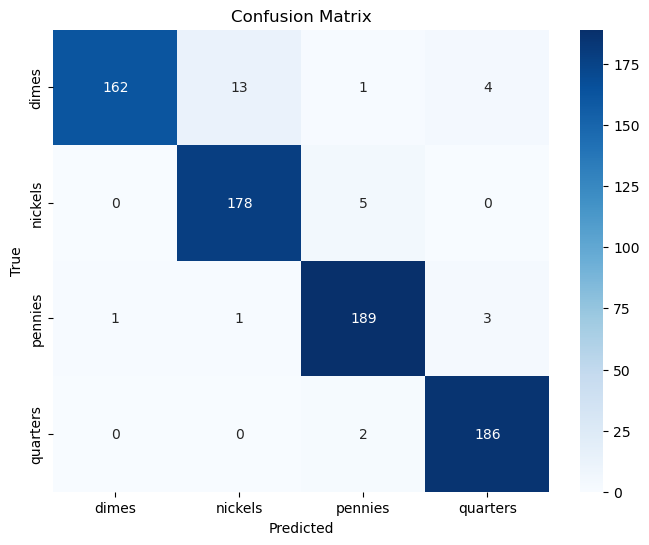

Classification Report:
              precision    recall  f1-score   support

       dimes       0.99      0.90      0.94       180
     nickels       0.93      0.97      0.95       183
     pennies       0.96      0.97      0.97       194
    quarters       0.96      0.99      0.98       188

    accuracy                           0.96       745
   macro avg       0.96      0.96      0.96       745
weighted avg       0.96      0.96      0.96       745



In [31]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(cr)


In [32]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

24/24 [==============================] - 5s 198ms/step - loss: 0.1347 - accuracy: 0.9597
Test Loss: 0.13467901945114136
Test Accuracy: 0.9597315192222595


24/24 [==============================] - 5s 214ms/step


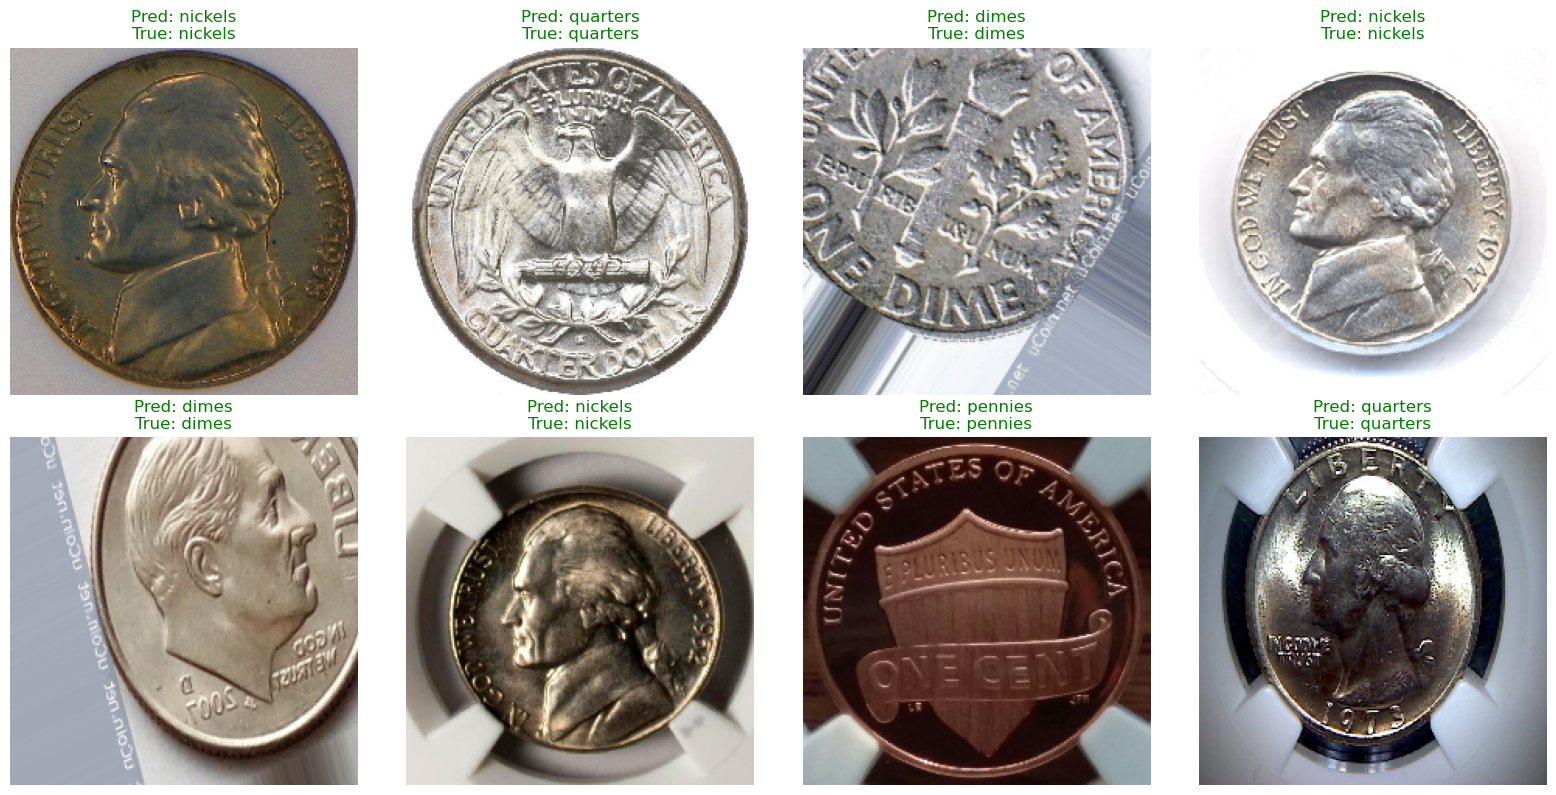

In [ ]:

class_labels = list(test_generator.class_indices.keys())

# Predict on the test set
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
test_img_paths = test_generator.filepaths

# Display a random set of sample predictions with images
num_samples = 8
random_idxs = random.sample(range(len(test_img_paths)), num_samples)

plt.figure(figsize=(16, 8))
for i, idx in enumerate(random_idxs):
    img = load_img(test_img_paths[idx], target_size=img_size)
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')
    pred_label = class_labels[y_pred[idx]]
    true_label = class_labels[y_true[idx]]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='green' if pred_label == true_label else 'red')
plt.tight_layout()
plt.show()